In [1]:
# import
# import
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import calendar

from scipy.optimize import bisect, minimize
from scipy.stats import norm, genextreme
from scipy.signal import find_peaks, savgol_filter
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline, CubicSpline

import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import os
import re

import asyncio
import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 30)
pd.set_option('display.float_format', '{:.6f}'.format)

In [2]:
from mypackage.bs import *
from mypackage.marketIV import *
from mypackage.moment import *

hello()

Hello, this is the test function!


In [ ]:
instruments = pd.read_csv(f"RND_data/deribit_data/instruments.csv")

year_list = instruments.query("type=='year'")
quarter_list = instruments.query("type=='quarter'")
week_list = instruments.query("type=='week'")
day_list = instruments.query("type=='day'")

#bnspot = pd.read_csv("RND_data/binance_data/BTCUSDT_spot.csv")

print("year:", len(year_list))
print("quarter:", len(quarter_list))
print("week:", len(week_list))
print("day:", len(day_list))

In [ ]:
# 日期轉換
a = datetime.strptime("2024-01-01", "%Y-%m-%d").strftime("%d%b%y").upper()
b = datetime.strptime("01JAN24", "%d%b%y").strftime("%Y-%m-%d")
print(a)
print(b)

# <a id='toc1_'></a>[**1. read deribit data**](#toc0_)

- call_strike
- put_strike
- df_idxprice
- df_futuresprice

In [3]:
def read_data_v2(expiration_date):

    #formatted_date = datetime.strptime(expiration_date, "%Y-%m-%d").strftime("%d%b%y").upper()

    call_iv = pd.read_csv(f"RND_data/asher_data/For RND/call_iv_{expiration_date}.csv", index_col="Unnamed: 0")
    call_iv.index = pd.to_datetime(call_iv.index)
    call_iv.index = call_iv.index.strftime('%Y-%m-%d')
    put_iv = pd.read_csv(f"RND_data/asher_data/For RND/put_iv_{expiration_date}.csv", index_col="Unnamed: 0")
    put_iv.index = pd.to_datetime(put_iv.index)
    put_iv.index = put_iv.index.strftime('%Y-%m-%d')
    df_idx = pd.read_csv(f"RND_data/asher_data/For RND/TX_index_{expiration_date}.csv", index_col="Unnamed: 0")
    df_idx.index = pd.to_datetime(df_idx.index)
    df_idx.index = df_idx.index.strftime('%Y-%m-%d')
    df_idx['index_price'] = df_idx['index_price'].str.replace(',', '').astype(float)

    call_iv.columns = call_iv.columns.astype(int)
    put_iv.columns = put_iv.columns.astype(int)

    call_price = pd.read_csv(f"RND_data/asher_data/For RND/call_strike_{expiration_date}.csv", index_col="Unnamed: 0")
    call_price.index = pd.to_datetime(call_price.index)
    call_price.index = call_price.index.strftime('%Y-%m-%d')
    put_price = pd.read_csv(f"RND_data/asher_data/For RND/put_strike_{expiration_date}.csv", index_col="Unnamed: 0")
    put_price.index = pd.to_datetime(put_price.index)
    put_price.index = put_price.index.strftime('%Y-%m-%d')

    call_price.columns = call_price.columns.astype(int)
    put_price.columns = put_price.columns.astype(int)
    
    #df_F = find_F_df(call_iv, put_iv, call_price, put_price, df_idx)

    return call_iv, put_iv, call_price, put_price, df_idx#, df_F

def find_F1(K, type):
    global observe_date, expiration_date, call_iv, put_iv, call_price, put_price, df_idx
    def calculate_call_price(F, K, sigma, T, S0):
        d1 = (np.log(F / K) + (sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return ( norm.cdf(d1) - K / F * norm.cdf(d2) ) * S0

    def calculate_put_price(F, K, sigma, T, S0):
        d1 = (np.log(F / K) + (sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return ( K / F * norm.cdf(-d2) - norm.cdf(-d1) ) * S0

    def newton_method(real_price, K, sigma, T, S, type, tolerance=1e-6, max_iterations=1000):
        F = S*0.8
        for _ in range(max_iterations):
            if type=="C":
                guess_price = calculate_call_price(F, K, sigma, T, S)
            elif type=="P":
                guess_price = calculate_put_price(F, K, sigma, T, S)

            F_new = F + abs(guess_price - real_price) * 0.5
            if abs(real_price - guess_price) < tolerance:
                return F_new
            F = F_new
            
        return F
    
    if type=="C":
        price = call_price[K].loc[observe_date]  
        sigma = call_iv[K].loc[observe_date]
    if type=="P":
        price = put_price[K].loc[observe_date]  
        sigma = put_iv[K].loc[observe_date]
    
    T = (pd.to_datetime(expiration_date) - pd.to_datetime(observe_date)).days /365 
    S = df_idx["index_price"].loc[observe_date]

    return newton_method(price, K, sigma, T, S, type)



def find_F2():
    global observe_date, expiration_date, call_iv, put_iv, call_price, put_price, df_idx
    S = df_idx["index_price"].loc[observe_date]
    df = call_price.loc[observe_date][call_price.loc[observe_date]!=0]
    result_c = df[(df.index >= S*0.9) & (df.index <= S*1.5)]
    result_c = pd.DataFrame(result_c)
    result_c.columns = ["C"]

    df = put_price.loc[observe_date][put_price.loc[observe_date]!=0]
    result_p = df[(df.index >= S*0.8) & (df.index <= S*1.1)]
    result_p = pd.DataFrame(result_p)
    result_p.columns = ["P"]

    F_values_c = [find_F1(K, "C") for K in result_c.index]
    F_values_p =  [find_F1(K, "P") for K in result_p.index]
    F = np.array(F_values_c+F_values_p).mean()
    #print(np.array(F_values_c+F_values_p))
    
    return F



In [4]:
def draw_IV_and_Call_v2(smooth_IV):
    global call_iv, put_iv, call_price, put_price, df_idx
    F = find_F2()

    # Fig1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    ax1.set_title(f"{observe_date} date\n{expiration_date} expiration\nsmooth IV(Call, Put)\nF={int(F)}")
    # (1) call iv scatter   
    call_iv_filt = call_iv.loc[observe_date][call_iv.loc[observe_date] != 0]
    ax1.scatter(call_iv_filt.index, call_iv_filt, label="call iv", marker="o", color="mediumseagreen", s=10)
    # (2) put iv scatter     
    put_iv_filt = put_iv.loc[observe_date][put_iv.loc[observe_date] != 0]
    ax1.scatter(put_iv_filt.index, put_iv_filt, label="put iv", marker="o", color="lightcoral", s=10)
    # (3) F
    ax1.plot([F]*2, [0.3, 1],  ":", color="black", label=f"futures price")
    # (4) smooth iv    
    ax1.plot(smooth_IV["K"], smooth_IV["mixIV"], color="royalblue", label=f"smooth iv")  
    ax1.set_xlim(0, F*2)
    ax1.set_ylim(min(min(call_iv_filt), min(put_iv_filt))-0.1, max(max(call_iv_filt), max(put_iv_filt))+0.1)

     # Fig2
    ax2.set_title("smooth call price")  
    # (1) call price scatter   
    call_price_filt = call_price.loc[observe_date][call_price.loc[observe_date] != 0]
    ax2.scatter(call_price_filt.index, call_price_filt, label="call price", marker="o", color="mediumseagreen", s=10)
    # (2) put price scatter     
    #put_price_filt = put_price.loc[observe_date][put_iv.loc[observe_date] != 0]
    #ax2.scatter(put_price_filt.index, put_price_filt, label="put iv", marker="o", color="lightcoral", s=10)
    # (3) smooth price    
    ax2.plot(smooth_IV["K"], smooth_IV["C"], alpha=0.8, label="smooth call price", color="royalblue")
    ax2.set_xlim(0, F*2)
    ax2.set_ylim(0, max(call_price_filt)*1.1)

    ax1.grid(linestyle='--', alpha=0.3), ax2.grid(linestyle='--', alpha=0.3)
    ax1.legend(), ax2.legend()
    plt.show()

In [5]:
def get_FTS():
    global observe_date, expiration_date
    F = find_F2()
    T = (pd.to_datetime(expiration_date) - pd.to_datetime(observe_date)).days/365
    S = df_idx["index_price"].loc[observe_date]
    return {"F": F, "T": T, "S": S}

In [6]:
def mix_cp_function_v2():
    global observe_date, expiration_date, call_iv, put_iv, call_price, put_price, df_idx
    basicinfo = get_FTS()
    F = basicinfo["F"]
    T = basicinfo["T"]
    S = basicinfo["S"]

    mix = pd.concat([call_iv.loc[observe_date], put_iv.loc[observe_date]], axis=1)
    mix.columns = ["C", "P"]
    mix = mix.replace(0, np.nan)

    # atm
    atm = mix.loc[(mix.index <= F*1.1) & (mix.index >= F*0.9)]
    atm["mixIV"] = atm[["C","P"]].mean(axis=1)

    # otm
    otm = pd.DataFrame(pd.concat([ mix.loc[mix.index < F*0.9, 'P'], mix.loc[mix.index > F*1.1, 'C'] ], axis=0), columns=["mixIV"])

    # mix
    mix_cp = pd.concat([atm, otm], axis=0).sort_index()
    mix_cp[["C","P"]] = mix
    mix_cp = mix_cp.dropna(subset=["mixIV"])
    mix_cp = mix_cp.loc[:F*2.5]
    
    return mix_cp

# 2. func

## <a id='toc2_5_'></a>[**2.5 DVF_function**](#toc0_)

### UnivariateSpline_function

In [7]:
def UnivariateSpline_function_v2(mix_cp, power=3, s=None, w=None):
    global observe_date, expiration_date
    basicinfo = get_FTS()
    F = basicinfo["F"]
    T = basicinfo["T"]
    S = basicinfo["S"]
    spline = UnivariateSpline(mix_cp.index, mix_cp["mixIV"], k=4, s=None, w=None) #三次样条插值，s=0：插值函数经过所有数据点
    
    min_K = 0 #int(min(oneday2["K"]) * 0.8) # 測試!!!!!!!!!!
    max_K = int(max(mix_cp.index)*1.2)#max(F*2//1000*1000, max(mix_cp.index)) +1
    dK = 1
    K_fine = np.arange(min_K, max_K, dK, dtype=np.float64)
    Vol_fine = spline(K_fine)

    smooth_IV = pd.DataFrame([K_fine, Vol_fine], index=["K", "mixIV"]).T
    """
    try:    # IV左邊有往下
        left_US = smooth_IV.query(f"K < {mix_cp.index[0]}")
        idx = left_US[left_US["mixIV"].diff() > 0].index[-1]
        smooth_IV = smooth_IV.loc[idx:].reset_index(drop=True)
    except: # IV左邊沒有往下
        pass
    """
    smooth_IV["C"] = call.future(F, smooth_IV["K"], T, smooth_IV["mixIV"], S)
    
    #smooth_IV = add_other_info(date, oneday2, smooth_IV, call_strike, df_idxprice, df_futuresprice, expiration_date, IVname)
    #smooth_IV.index = smooth_IV["K"].values
    return smooth_IV

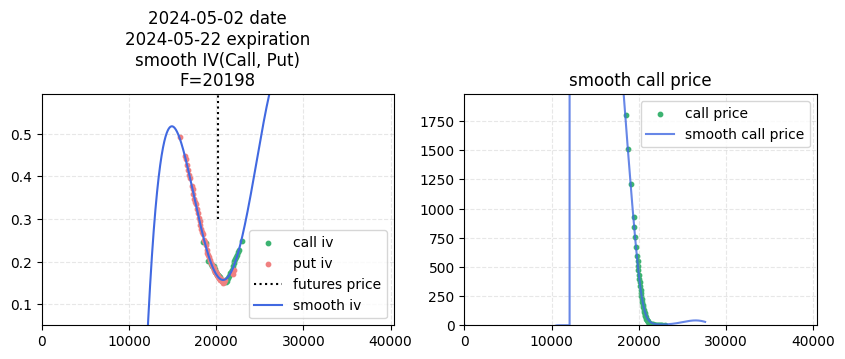

In [8]:
# RND main 
observe_date = "2024-05-02"
expiration_date = "2024-05-22"

call_iv, put_iv, call_price, put_price, df_idx = read_data_v2(expiration_date)

F = find_F2()

mix_cp = mix_cp_function_v2()

smooth_IV = UnivariateSpline_function_v2(mix_cp, power=4)

draw_IV_and_Call_v2(smooth_IV)

## <a id='toc2_6_'></a>[**2.6 RND**](#toc0_)

In [9]:
# RND
def RND_function(smooth_IV):
    
    # 方法一 直接微分
    smooth_IV["cdf"] = np.gradient(smooth_IV['C'], smooth_IV['K'])+1
    smooth_IV["pdf"] = np.gradient(np.gradient(smooth_IV['C'], smooth_IV['K']), smooth_IV['K'])

    # 方法二
    dk = smooth_IV["K"].iloc[1] - smooth_IV["K"].iloc[0]
    smooth_IV["RND"] =  (smooth_IV["C"].shift(1) + smooth_IV["C"].shift(-1) - 2*smooth_IV["C"]) / ((dk)**2) #np.exp(r*T) *
    smooth_IV = smooth_IV.dropna()

    # RND 平滑
    smooth_IV["RND"] = savgol_filter(smooth_IV["RND"], 500, 3) # 平滑

    return smooth_IV

In [10]:
# 找出正常區間的RND
def RND2_function(smooth_IV):
    global ITM, vally, der3, peak

    basicinfo = get_FTS()
    F = basicinfo["F"]
    T = basicinfo["T"]
    S = basicinfo["S"]

    df = smooth_IV.copy()
    df["RND_diff"] = df["RND"] - df["RND"].shift(1)
    max_idx = df.query(f"K>{F*0.7} & K<{F*1.3}")["RND"].idxmax() # 價平附近的最大RND
    print("maxidx", max_idx)
    # 1. 左尾
    #   (1) 若有三次微分高點
    try:     
        der1 = (df["C"].diff() / df["K"].diff()).fillna(np.nan)
        der2 = der1.diff().fillna(np.nan)
        der3 = der2.diff().fillna(np.nan)
        der3 = savgol_filter( der3.fillna(method='bfill'),35000, 3)
        der3 = pd.Series(der3, index=der1.index)
        
        ITM = der3.loc[:max_idx-5000]
        vally = ITM.copy()
        conditions = []

        for i in range(1, 500):
            conditions.append((ITM.shift(-i) < ITM) & (ITM > ITM.shift(i)))

        for condition in conditions:
            vally = vally[condition]
            
        startidx1 = int(vally.index[-1] ) #*1.2#*0.9 # -5000  #* 0.7 #0.8
    except:  
        startidx1 = 0
    
    #   (2) 翹起
    try:     
        startidx2 = int(df.loc[:max_idx-5000].query(f"RND_diff<0").index[-1] )#*1.2
    except:  
        startidx2 = 0
    
    print("startidx1", startidx1, "startidx2", startidx2)
    if startidx1 > startidx2 and startidx2 !=0:
        startidx = startidx2 + (startidx1 - startidx2) * 0.5
        print("startidx", startidx)
    else:
        startidx = max(startidx1*0.8, startidx2*1.2)
    

    if (df["RND"].loc[startidx:int(F)]<=0).sum() >= 1: #有負值
        startidx = int(df.loc[:int(F)].query("RND<0").index[-1] * 1.05)


    #   右尾
    try:     # 若有翹起
        endidx = df.loc[max_idx+5000:].query(f"RND_diff>0").index[0]
    except:  # 若無翹起
        endidx = len(df)
    #RND2 =  df.loc[startidx-1:endidx-1]

    print(startidx-1,endidx-1000)
    RND2 =  df.loc[startidx-1:endidx-1000]


    # 2. 無負值
    RND2["RND"] = np.where(RND2["RND"] < 0, np.nan, RND2["RND"])
    RND2 = RND2.dropna()
    RND2["CDF"] = RND2["RND"].cumsum()
    RND2["RND_quantile"] = RND2["CDF"]/RND2["CDF"].iloc[-1]
    
    return RND2

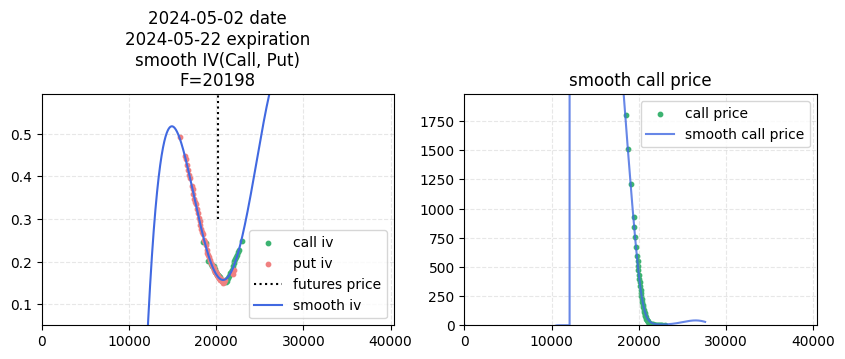

maxidx 20329
startidx1 0 startidx2 15329
18393.8 25932


In [13]:
# RND main 
observe_date = "2024-05-02"
expiration_date = "2024-05-22"
call_iv, put_iv, call_price, put_price, df_idx = read_data_v2(expiration_date)

mix_cp = mix_cp_function_v2()
smooth_IV = UnivariateSpline_function_v2(mix_cp, power=4)
draw_IV_and_Call_v2(smooth_IV)

smooth_IV = RND_function(smooth_IV)
RND2 = RND2_function(smooth_IV)        

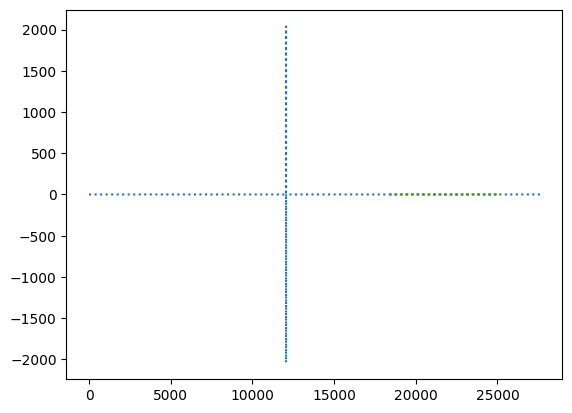

In [15]:
plt.plot(smooth_IV["pdf"],':')
plt.plot(RND2["RND"],':')
plt.plot(RND2["pdf"],':')

In [16]:
left_cdf = RND2["cdf"].iloc[0] - RND2["pdf"].iloc[0] 
right_cdf = (1-RND2["cdf"].iloc[-1]) - RND2["pdf"].iloc[-1] 
print(left_cdf, right_cdf)

0.021630337216720363 -0.01444997781868107


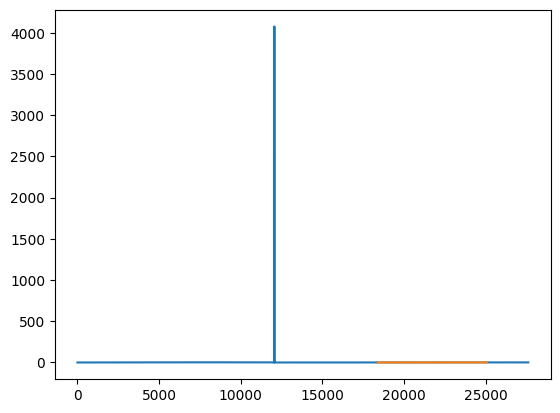

In [17]:
plt.plot(smooth_IV["cdf"])
plt.plot(RND2["cdf"])

## <a id='toc2_7_'></a>[**2.7 GEV_function**](#toc0_)
- FitGEVRightTail
- FitGEVLeftTail
- CDF_GEV(S, Mean, sigma, phi)
- PDF_GEV(S, Mean, sigma, phi)

In [21]:
# 找最佳GEV參數 FitGEVRightTail FitGEVLeftTail
def FitGEVRightTail(beta, a0, a1, a2, Ka0, Ka1, Ka2, fKa0, fKa1, fKa2, FKa0R): # 確認與matlab無誤
    Mean, sigma, phi = beta[0], beta[1], beta[2]

    pdf0 = genextreme(phi, loc=Mean, scale=sigma).pdf(Ka0)
    pdf1 = genextreme(phi, loc=Mean, scale=sigma).pdf(Ka1)
    pdf2 = genextreme(phi, loc=Mean, scale=sigma).pdf(Ka2)
    cdf0 = genextreme(phi, loc=Mean, scale=sigma).cdf(Ka0)

    y = ( pdf0 - fKa0 )**2 + \
        ( pdf1 - fKa1 )**2 + \
        ( pdf2 - fKa2 )**2 #+ \
        #( cdf0 - FKa0R )**2 

    #if phi <= 0:
    #    y = 1e100

    return y

# 有反轉
def FitGEVLeftTail(beta, a0, a1, a2, Ka0, Ka1, Ka2, fKa0, fKa1, fKa2, FKa0L): # 確認與matlab無誤 # 改版1
    Mean, sigma, phi = beta[0], beta[1], beta[2]

    pdf0 = genextreme(phi, loc=Mean, scale=sigma).pdf(-Ka0)
    pdf1 = genextreme(phi, loc=Mean, scale=sigma).pdf(-Ka1)
    pdf2 = genextreme(phi, loc=Mean, scale=sigma).pdf(-Ka2)
    pdf3 = genextreme(phi, loc=Mean, scale=sigma).pdf(0) # K=0時的CDF
    cdf0 = genextreme(phi, loc=Mean, scale=sigma).cdf(-Ka0)
    
    y = ( pdf0 - fKa0 )**2 + \
        ( pdf1 - fKa1 )**2 + \
        pdf3 ** 2 #+ \
        #( cdf0 - (1-FKa0L) )**2
    
        #( pdf2 - fKa2 )**2# + \
        
    if pdf3 <= 0:
        y = 1e100    
    
    return y

In [22]:
# 右尾 GEV_Right_function
start_right_phi = 0

basicinfo = get_FTS()
F = basicinfo["F"]
right_edge = int(F*3)

a0R = 0.95
a1R = 0.98
a2R = 0.99

def GEV_Right_function(RND2):
    global Ka0R, Ka1R, Ka2R, fKa0R, fKa1R, fKa2R, a0R, a1R, a2R, start_right_phi, right_edge

    basicinfo = get_FTS()
    F = basicinfo["F"]
    T = basicinfo["T"]
    S = basicinfo["S"]

    Ka0R = RND2.query(f"RND_quantile>{a0R}").iloc[0]["K"] # Ka0R = RND2.query(f"RND_quantile>{a0R}").iloc[0]["K"]
    Ka1R = RND2.query(f"RND_quantile>{a1R}").iloc[0]["K"]
    Ka2R = RND2.query(f"RND_quantile>{a2R}").iloc[0]["K"]
    fKa0R = np.interp(Ka0R, RND2["K"], RND2["RND"]) 
    fKa1R = np.interp(Ka1R, RND2["K"], RND2["RND"])
    fKa2R = np.interp(Ka2R, RND2["K"], RND2["RND"])
    FKa0R = np.interp(Ka0R, RND2["K"], RND2["cdf"]) 
    
    # 找 GEV 參數
    options = {'maxfun': 1e10, 'maxiter': 1e10}

    # (1)
    start1 = [F, 4000, start_right_phi] # -29000, 5000, -0.2 # -25000, 1500, -0.1 # -0.7
    result1 = minimize(FitGEVRightTail, start1, args=(a0R, a1R, a2R, Ka0R, Ka1R, Ka2R, fKa0R, fKa1R, fKa2R, FKa0R), method='Nelder-Mead', options=options, tol=1e-8)
    
    Mean, sigma, phi = result1.x

    print(f"右尾: {', '.join([f'{x:.2f}' for x in result1.x])}")
    print("FKa0R", FKa0R)
    print("cdf Ka0R", genextreme(phi, loc=Mean, scale=sigma).cdf(Ka0R))
    
    # max_K = max(F*4//1000*1000, max(oneday2["K"])) +1
    #K3 = np.arange(int(Ka0R*0.9), max(80000, F*2//1000*1000), 1) # max(mix_cp["K"])*2 # Ka0R*2
    #K3 = np.arange(int(Ka0R*0.4), int(F*3), 1) # 統一補到F*3
    K3 = np.arange(int(Ka0R*0.8), right_edge, 1) # 統一補到F*3
    #K3 = np.arange(int(Ka0R*0.9), 80000, 1) # 統一補到10萬
    GEV_right = [genextreme(phi, loc=Mean, scale=sigma).pdf(k) for k in K3]
    return K3, GEV_right, result1.x

In [23]:
# 左尾 GEV_Left_function
start_left_phi = -0.1

a0L = 0.01 
a1L = 0.03 
a2L = 0.05

def GEV_Left_function(RND2):
    global Ka0L, Ka1L, Ka2L, fKa0L, fKa1L, fKa2L, a0L, a1L, a2L

    
    basicinfo = get_FTS()
    F = basicinfo["F"]
    T = basicinfo["T"]
    S = basicinfo["S"]

    Ka0L = RND2.query(f"RND_quantile<{a0L}").iloc[-1]["K"]
    Ka1L = RND2.query(f"RND_quantile<{a1L}").iloc[-1]["K"]
    Ka2L = RND2.query(f"RND_quantile<{a2L}").iloc[-1]["K"]
    fKa0L = np.interp(Ka0L, RND2["K"], RND2["RND"])
    fKa1L = np.interp(Ka1L, RND2["K"], RND2["RND"])
    fKa2L = np.interp(Ka2L, RND2["K"], RND2["RND"])
    FKa0L = np.interp(Ka0L, RND2["K"], RND2["cdf"]) 

    # 找 GEV 參數
    options = {'maxfun': 1e2, 'maxiter': 1e2}

    # (1)
    start1 = [-F, 20000, start_left_phi]  # 起始mean為負
    result1 = minimize(FitGEVLeftTail, start1, args=(a0L, a1L, a2L, Ka0L, Ka1L, Ka2L, fKa0L, fKa1L, fKa2L, FKa0L), method='Nelder-Mead', options=options, tol=1e-8)
    Mean, sigma, phi = result1.x

    print(f"左尾: {', '.join([f'{x:.2f}' for x in result1.x])}")
    print("cdf of 4-th polynomial: ", FKa0L)
    print("cdf of gev", 1-genextreme(phi, loc=Mean, scale=sigma).cdf(Ka0L))

    K4 = np.arange(0, int(Ka0L*2), 1)
    GEV_left = [genextreme(phi, loc=Mean, scale=sigma).pdf(-k) for k in K4] #-k
    GEV_left_old = [genextreme(phi, loc=Mean, scale=sigma).pdf(k) for k in K4] #k
    return K4, GEV_left, result1.x

In [24]:
# 合併左右尾 mix_RND_GEV
def mix_RND_GEV(RND2, K3, GEV_right, K4, GEV_left):
    global observe_date, expiration_date

    #Body = np.column_stack((RND2["K"], RND2["RND"]))
    #df_Body = pd.DataFrame(Body, columns=["K","Body"])
    df_Body = RND2[["K", "RND", "mixIV"]]
    df_Body.columns = ["K", "Body", "mixIV"]

    basicinfo = get_FTS()
    F = basicinfo["F"]
    T = basicinfo["T"]
    S = basicinfo["S"]

    # Right
    df_Right = pd.DataFrame([K3, GEV_right], index=["K","Right"]).T
    df_main = df_Body.merge(df_Right, on="K", how='outer')


    # Left
    if isinstance(K4, np.ndarray):
        df_Left = pd.DataFrame([K4, GEV_left], index=["K","Left"]).T
        df_main = df_main.merge(df_Left, on="K", how='outer')
        df_main["meanLeft"] = df_main.query(f"K<{Ka0L}")[["Left"]].mean(axis=1, skipna=True) #"Body",
    else:
        df_main["meanLeft"] = 0

    df_main = df_main.sort_values("K").reset_index(drop=True)
    df_main.replace([np.inf, -np.inf], np.nan, inplace=True)

    # 若normal右尾已經很大
    
    #if RND2["K"].max() > max(80000,(F*2//1000*1000)):
    if RND2["K"].max() > right_edge: # <-------------
        df_main["meanRight"] = df_main.query(f"K>{Ka0R}")[["Body"]].mean(axis=1, skipna=True) 
    else:
        df_main["meanRight"] = df_main.query(f"K>{Ka0R}")[["Right"]].mean(axis=1, skipna=True) #"Body",

    df_main["RND"] = df_main["meanRight"] 
    df_main["RND"] = df_main["RND"].fillna(df_main["meanLeft"])
    df_main["RND"] = df_main["RND"].fillna(df_main["Body"])

    df_main["RND"] = np.where(df_main["RND"] < 0, 0, df_main["RND"])
    df_main["RND"] = savgol_filter(df_main["RND"], 500, 3) # 平滑
 
    df_main = df_main.query(f"K<{right_edge}") #測試  # <-------------


    df_main["CDF"] = df_main["RND"].cumsum()

    """
    # === 調整 CDF ===
    cdf_value = df_main["CDF"].iloc[-1]
    cdf_multiple = 1 / cdf_value
    df_main["RND"] = df_main["RND"] * cdf_multiple # RND_adjust
    df_main["CDF"] = df_main["RND"].cumsum() # CDF_adjust
    """
    return df_main

In [25]:
observe_date = "2024-05-02"
expiration_date = "2024-05-22"
call_iv, put_iv, call_price, put_price, df_idx = read_data_v2(expiration_date)

mix_cp = mix_cp_function_v2()
smooth_IV = UnivariateSpline_function_v2(mix_cp, power=4)
smooth_IV = RND_function(smooth_IV)
RND2 = RND2_function(smooth_IV)      

maxidx 20329
startidx1 0 startidx2 15329
18393.8 25932


In [26]:
# 右尾
K3, GEV_right, param_right = GEV_Right_function(RND2)

# 左尾
K4, GEV_left, param_left = GEV_Left_function(RND2)

# 合併RND GEV
df_main = mix_RND_GEV(RND2, K3, GEV_right, K4, GEV_left)

右尾: 21280.22, 0.10, -3.90
FKa0R 0.9647640419097883
cdf Ka0R 0.9091505956651134
左尾: -20259.99, 381.91, -0.13
cdf of 4-th polynomial:  0.03153706498244446
cdf of gev 1.0708245401502836e-09


Text(0, 0.5, 'Risk Neutral Density')

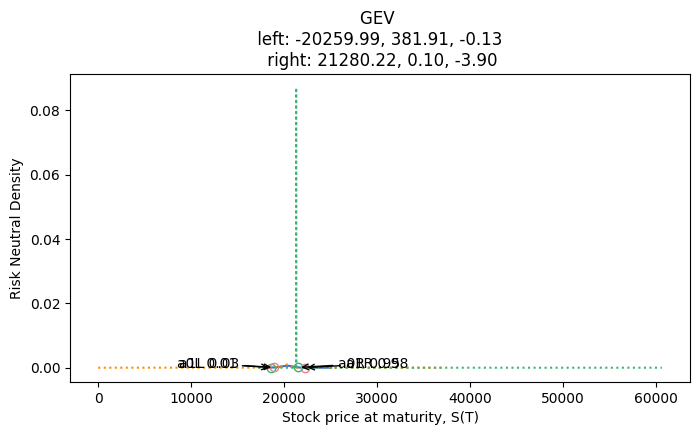

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.set_title(f"GEV \n left: {', '.join([f'{x:.2f}' for x in param_left])} \n right: {', '.join([f'{x:.2f}' for x in param_right])}")
ax.plot(RND2["K"], RND2["RND"], label='DVF RND', color="royalblue")
ax.plot(K4, GEV_left, ':', label='GEV for right tail', color="darkorange")
ax.plot(K3, GEV_right, ':', label='GEV for right tail', color="mediumseagreen")
ax.plot(Ka0R, fKa0R, 'o', markerfacecolor='none', label='a0R anchor', color="mediumseagreen")
ax.plot(Ka1R, fKa1R, 'o', markerfacecolor='none', label='a1R anchor', color="lightcoral")

ax.plot(Ka0L, fKa0L, 'o', markerfacecolor='none', label='a0R anchor', color="mediumseagreen")
ax.plot(Ka1L, fKa1L, 'o', markerfacecolor='none', label='a1R anchor', color="lightcoral")


ax.annotate(f'a0L {a0L}', xy=(Ka0L, fKa0L), xytext=(Ka0L*0.8, fKa0L*1.1),
                arrowprops=dict(arrowstyle='->'), fontsize=10, ha="right")


ax.annotate(f'a1L {a1L}', xy=(Ka1L, fKa1L), xytext=(Ka1L*0.8, fKa1L*1.2),
                arrowprops=dict(arrowstyle='->'), fontsize=10, ha="right")


ax.annotate(f'a0R {a0R}', xy=(Ka0R, fKa0R), xytext=(Ka0R*1.2, fKa0R*1.3),
                arrowprops=dict(arrowstyle='->'), fontsize=10, ha="left")


ax.annotate(f'a1R {a1R}', xy=(Ka1R, fKa1R), xytext=(Ka1R*1.2, fKa1R*1.1),
                arrowprops=dict(arrowstyle='->'), fontsize=10, ha="left")

ax.set_xlabel('Stock price at maturity, S(T)')
ax.set_ylabel('Risk Neutral Density')

NameError: name 'param_left' is not defined

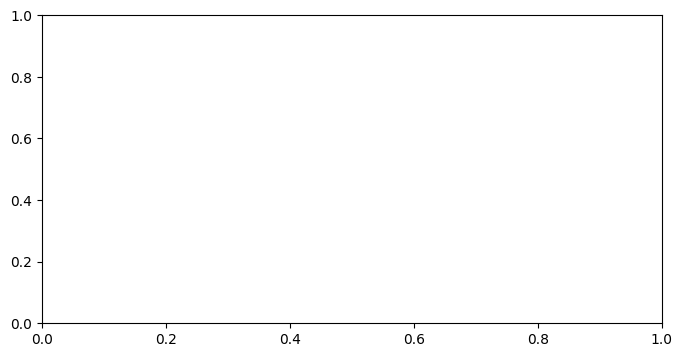

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.set_title(f"GEV \n left: {', '.join([f'{x:.2f}' for x in param_left])} \n right: {', '.join([f'{x:.2f}' for x in param_right])}")
ax.plot(RND2["K"], RND2["RND"], label='DVF RND', color="royalblue")
ax.plot(K4, GEV_left, ':', label='GEV for right tail', color="darkorange")
ax.plot(-K4, GEV_left, ':', label='GEV for right tail', color="mediumseagreen")

ax.plot(Ka0L, fKa0L, 'o', markerfacecolor='none', label='a0R anchor', color="mediumseagreen")
ax.plot(Ka1L, fKa1L, 'o', markerfacecolor='none', label='a1R anchor', color="lightcoral")

ax.annotate(f'a0L {a0L}', xy=(Ka0L, fKa0L), xytext=(Ka0L*0.8, fKa0L*1.1),
                arrowprops=dict(arrowstyle='->'), fontsize=10, ha="right")

ax.annotate(f'a1L {a1L}', xy=(Ka1L, fKa1L), xytext=(Ka1L*0.8, fKa1L*1.2),
                arrowprops=dict(arrowstyle='->'), fontsize=10, ha="right")

ax.set_xlabel('Stock price at maturity, S(T)')
ax.set_ylabel('Risk Neutral Density')

### 手動擬合尾部

# <a id='toc3_'></a>[**3. MAIN**](#toc0_)

In [18]:
def daily_rnd():
    global observe_date, expiration_date, call_iv, put_iv, call_price, put_price, df_idx

    # 讀取資料
    basicinfo = get_FTS()
    F = basicinfo["F"]
    T = basicinfo["T"]
    S = basicinfo["S"]
    
    # 處理市場數據
    mix_cp = mix_cp_function_v2()

    # 平滑 IV
    smooth_IV = UnivariateSpline_function_v2(mix_cp, power=4)

    # 計算RND
    smooth_IV = RND_function(smooth_IV)
    RND2 = RND2_function(smooth_IV)      
    
    # 右尾
    K3, GEV_right, param_right = GEV_Right_function(RND2)

    # 左尾
    K4, GEV_left, param_left = GEV_Left_function(RND2)

    # 合併RND GEV
    df_main = mix_RND_GEV(RND2, K3, GEV_right, K4, GEV_left)
    
    # 測試!!!
    #df_main = df_main.query("CDF<=1")  # 測試: 只取到CDF=1 !!!
    #df_main["RND"] = df_main["RND"] + (1-df_main["CDF"].iloc[-1])/len(df_main)
    #df_main["CDF"] = df_main["RND"].cumsum()


    # 綜合圖表
    fig, ax = plt.subplots(2, 3, figsize=(18, 8))

    rnd2_startK = RND2["K"].iloc[0]
    rnd2_endK = RND2["K"].iloc[-1]
    rnd2_highestIV = RND2["mixIV"].max()
    rnd2_lowestIV = RND2["mixIV"].min()

    call_iv_filt = call_iv.loc[observe_date][call_iv.loc[observe_date] != 0]
    put_iv_filt = put_iv.loc[observe_date][put_iv.loc[observe_date] != 0]

    # Fig1

    ax[0, 0].set_title(f"{observe_date} date\n{expiration_date} expiration\nsmooth IV(Call, Put)\nF={int(F)}")
    ax[0, 0].scatter(call_iv_filt.index, call_iv_filt, label="call iv", marker="o", color="mediumseagreen", s=10)  # call iv點
    ax[0, 0].scatter(put_iv_filt.index, put_iv_filt, label="put iv", marker="o", color="lightcoral", s=10)         # put iv點
    ax[0, 0].plot([F]*2, [rnd2_lowestIV-0.1, rnd2_highestIV+0.1],  ":", color="black", label=f"futures price")            # futures price
    ax[0, 0].plot(smooth_IV["K"], smooth_IV["mixIV"], color="royalblue", label=f"smooth iv")                       # smooth iv線 
    ax[0, 0].scatter(rnd2_startK, RND2["mixIV"].iloc[0], color="black")                                          # 正常 RND 範圍的左點
    ax[0, 0].scatter(rnd2_endK, RND2["mixIV"].iloc[-1], color="black")                                           # 正常 RND 範圍的右點
    ax[0, 0].set_xlim(min(rnd2_startK, put_iv_filt.index[0])-1000, max(rnd2_endK, call_iv_filt.index[0])+1000)   # x軸範圍
    ax[0, 0].set_ylim(rnd2_lowestIV-0.1, rnd2_highestIV+0.1)                                                         # y軸範圍
    
    # Fig2
    call_price_filt = call_price.loc[observe_date][call_price.loc[observe_date] != 0]  
    ax[0, 1].set_title("smooth Call price")                                      
    ax[0, 1].scatter(call_price_filt.index, call_price_filt, label="call price", marker="o", color="mediumseagreen", s=10)   # call iv點
    ax[0, 1].plot(smooth_IV["K"], smooth_IV["C"], alpha=0.8, label="smooth call price", color="royalblue")          # smooth price線  
    ax[0, 1].scatter(rnd2_startK, RND2["C"].iloc[0], color="black")                                              # 正常 RND 範圍的左點
    ax[0, 1].scatter(rnd2_endK, RND2["C"].iloc[-1],  color="black")                                               # 正常 RND 範圍的右點       
    ax[0, 1].set_xlim(min(rnd2_startK, put_iv_filt.index[0])-1000, max(rnd2_endK, call_iv_filt.index[0])+1000)  # x軸範圍
    ax[0, 1].set_ylim(0, RND2["C"].max()*1.2)                                                        # y軸範圍
    
    # Fig3
    ax[0, 2].set_title("DVF RND")
    ax[0, 2].plot(smooth_IV.query(f"K>{rnd2_startK-1000} & K<{rnd2_endK+1000}")["K"], 
                  smooth_IV.query(f"K>{rnd2_startK-1000} & K<{rnd2_endK+1000}")["RND"], label='DVF RND', color="royalblue")  # RND1 線
    ax[0, 2].set_xlabel('Stock price at maturity, S(T)')
    ax[0, 2].set_ylabel('Density', color='royalblue')
    ax[0, 2].scatter(RND2["K"].iloc[0], RND2["RND"].iloc[0], color="black")
    ax[0, 2].scatter(RND2["K"].iloc[-1], RND2["RND"].iloc[-1], color="black")

    cdf = RND2["RND"].cumsum()
    ax_twin = ax[0, 2].twinx()
    ax_twin.plot(RND2["K"], cdf , color="darkorange", label='CDF')
    ax_twin.set_ylabel('CDF', color='darkorange')
    ax_twin.tick_params('y', colors='darkorange')
    cdf_value = round(cdf.iloc[-1],4)
    ax_twin.annotate(f'CDF: {cdf_value}', xy=(RND2["K"].iloc[-1], cdf_value),
                xytext=(RND2["K"].iloc[-1]*0.8, cdf_value - 0.1),
                arrowprops=dict(arrowstyle='->'),
                fontsize=10)
    ax_twin.legend(loc='center right', bbox_to_anchor=(1, 0.4))


    # Fig4
    ax[1, 0].set_title(f"Find the GEV for the Right tail \n {', '.join([f'{x:.2f}' for x in param_right])}")
    ax[1, 0].plot(RND2["K"], RND2["RND"], label='DVF RND', color="royalblue")
    ax[1, 0].plot(K3, GEV_right, ':', label='GEV for right tail', color="darkorange")
    ax[1, 0].plot(Ka0R, fKa0R, 'o', markerfacecolor='none', label='a0R anchor', color="mediumseagreen")
    ax[1, 0].plot(Ka1R, fKa1R, 'o', markerfacecolor='none', label='a1R anchor', color="lightcoral")
    #ax[1, 0].plot(Ka2R, fKa2R, 'o', markerfacecolor='none', label='a1R anchor', color="gray")

    ax[1, 0].set_xlabel('Stock price at maturity, S(T)')
    ax[1, 0].set_ylabel('Risk Neutral Density')

    # Fig5
    ax[1, 1].set_title(f"Find the GEV for the Left tail \n {', '.join([f'{x:.2f}' for x in param_left])}")
    ax[1, 1].plot(RND2["K"], RND2["RND"], label='DVF RND', color="royalblue")
    ax[1, 1].plot(K4, GEV_left, ':', label='GEV for left tail', color="darkorange")
    ax[1, 1].plot(Ka0L, fKa0L, 'o', markerfacecolor='none', label= 'a0 anchor', color="mediumseagreen")
    ax[1, 1].plot(Ka1L, fKa1L, 'o', markerfacecolor='none', label='a1 anchor', color="lightcoral")
    #ax[1, 1].plot(Ka2L, fKa2L, 'o', markerfacecolor='none', label='a2 anchor', color="gray")

    ax[1, 1].set_xlabel('Stock price at maturity, S(T)')
    ax[1, 1].set_ylabel('Risk Neutral Density')


    # Fig6
    ax[1, 2].set_title("Final RND(DVF+GEV)")
    ax[1, 2].plot(df_main["K"], df_main["RND"], color="royalblue", label='RND')
    ax[1, 2].set_xlabel('Stock price at maturity, S(T)')
    ax[1, 2].set_ylabel('Density', color='royalblue')
    ax[1, 2].tick_params('y', colors='royalblue')
    try:
        ax[1, 2].plot(Ka1L, df_main.query(f"K=={Ka1L}")["RND"], 'o', markerfacecolor='none')
        ax[1, 2].plot(Ka0L, df_main.query(f"K=={Ka0L}")["RND"], 'o', markerfacecolor='none')
    except:
        ax[1, 2].plot(Ka1L, RND2.query(f"K=={Ka1L}")["RND"], 'o', markerfacecolor='none')
        ax[1, 2].plot(Ka0L, RND2.query(f"K=={Ka0L}")["RND"], 'o', markerfacecolor='none')
        pass
    try:
        ax[1, 2].plot(Ka1R, df_main.query(f"K=={Ka1R}")["RND"], 'o', markerfacecolor='none')
        ax[1, 2].plot(Ka0R, df_main.query(f"K=={Ka0R}")["RND"], 'o', markerfacecolor='none')
    except:
        ax[1, 2].plot(Ka1R, RND2.query(f"K=={Ka1R}")["RND"], 'o', markerfacecolor='none')
        ax[1, 2].plot(Ka0R, RND2.query(f"K=={Ka0R}")["RND"], 'o', markerfacecolor='none')

    #    futures price
    ax[1, 2].plot([F]*2, [max(df_main["RND"]),min(df_main["RND"])], ":", color="black", label="Futures") 

    ax_twin = ax[1, 2].twinx()
    ax_twin.plot(df_main["K"], df_main["CDF"] , color="darkorange", label='CDF')
    ax_twin.set_ylabel('CDF', color='darkorange')
    ax_twin.tick_params('y', colors='darkorange')
    cdf_value = round(df_main["CDF"].iloc[-1], 4)
    ax_twin.annotate(f'CDF: {cdf_value}', xy=(df_main["K"].iloc[-1], cdf_value),
                xytext=(df_main["K"].iloc[-1]*0.8, cdf_value - 0.1),
                arrowprops=dict(arrowstyle='->'),
                fontsize=10)
    ax_twin.legend(loc='center right', bbox_to_anchor=(1, 0.3))

    # step3: calculate skewness, kurtosis
    weighted_mean, weighted_std, weighted_skew, excess_kurt = get_moment(df_main)


    ax_twin.text(df_main["K"].iloc[-1]*0.8, 0.7, f"skew: {round(weighted_skew,2)}")
    ax_twin.text(df_main["K"].iloc[-1]*0.8, 0.6, f"kurt: {round(excess_kurt,2)}")

    for i in range(2):
        for j in range(3):
            ax[i, j].grid(linestyle='--', alpha=0.4)
            ax[i, j].legend()
    ax[0, 2].legend(loc='center right')
    ax[1, 2].legend(loc='center right', bbox_to_anchor=(1, 0.4))

    plt.tight_layout()
    plt.show()


    atm_iv = smooth_IV.query(f"K > { F } ")["mixIV"].iloc[0]
    #lowest_iv = smooth_IV.query(f"K>{rnd2_startK} & K<{rnd2_endK}")["mixIV"].min()
    lowest_iv = smooth_IV.query(f"K>{F*0.8} & K<{F*1.2}")["mixIV"].min()
    #d25_iv_diff = smooth_IV.query(f"K >= { F*1.15 } ")["mixIV"].iloc[0] - smooth_IV.query(f"K >= { F*0.85 } ")["mixIV"].iloc[0]
 
    delta = df_main.dropna(subset=["mixIV"])

    delta["Cdelta"] = norm.cdf( (np.log(F/delta["K"])+(delta["mixIV"]**2/2)*T) / (delta["mixIV"] * np.sqrt(T)) )
    delta["Pdelta"] = norm.cdf( (np.log(F/delta["K"])+(delta["mixIV"]**2/2)*T) / (delta["mixIV"] * np.sqrt(T)) )-1

    d25_calliv = delta.query("Cdelta>=0.25").iloc[0]["mixIV"]
    d25_putiv = delta.query("Pdelta<=-0.25").iloc[0]["mixIV"]
    d25_iv_diff = d25_calliv-d25_putiv

    q5_moneyness = df_main.query("CDF >= 0.05")["K"].iloc[0] / F
    q95_moneyness = df_main.query("CDF <= 0.95")["K"].iloc[-1] / F

    result = {"df":df_main,
              "skew":round(weighted_skew,2),
              "kurt":round(excess_kurt,2),
              "param_right":param_right,
              "param_left":param_left,
              "atm_iv":atm_iv,
              "lowest_iv":lowest_iv,
              "d25_iv_diff":d25_iv_diff,
              "q5_moneyness":q5_moneyness,
              "q95_moneyness":q95_moneyness,
              }

    return result

In [19]:
observe_date = "2024-05-02"
expiration_date = "2024-05-22"

call_iv, put_iv, call_price, put_price, df_idx = read_data_v2(expiration_date)
result = daily_rnd()

#RND_dict_1[expiration_date][observe_date] =  result["df"]
#skew_dict_1[expiration_date][observe_date] =  result["skew"]
#kurt_dict_1[expiration_date][observe_date] =  result["kurt"]
#right_dict_1[expiration_date][observe_date] =  result["param_right"]
#left_dict_1[expiration_date][observe_date] =  result["param_left"]
#df_ivinfo.loc[observe_date] = [result["atm_iv"], result["lowest_iv"], result["d25_iv_diff"], expiration_date]

result["df"]

maxidx 20329
startidx1 0 startidx2 15329
18393.8 25932


NameError: name 'GEV_Right_function' is not defined

In [ ]:
'''
# 取代1
RND_dict_1[date] =  df
skew_dict_1[date] =  skew
kurt_dict_1[date] =  kurt
right_dict_1[date] =  param_right
left_dict_1[date] =  param_left
df_ivinfo.loc[date] = [result["atm_iv"], result["lowest_iv"], result["d25_iv_diff"], expiration_date]
print(expiration_date, "done")
'''

# 以下還沒跑過（2024/06/25）
# 5. 單日多個T的RND

In [ ]:
# 創建 date list 
# (1) 每隔30天 # 05/01~06/30
start_date = datetime(2021, 5, 1)
end_date = datetime(2021, 5, 30)

date_list = []
while start_date < end_date:
    date_list.append(start_date.strftime('%Y-%m-%d'))
    start_date += timedelta(days=1) 

observe_list = [str(date) for date in date_list]    
print(observe_list)    

In [ ]:
# 創建 date list 
# (2) 每個月1號
start_date = datetime(2022, 5, 1)
end_date = datetime(2022, 12, 31)

date_list = []
current_date = start_date
while current_date <= end_date:
    date_list.append(current_date.strftime('%Y-%m-%d'))
    current_date += timedelta(days=32)
    current_date = datetime(current_date.year, current_date.month, 1) 

observe_list = [str(date) for date in date_list]    
print(observe_list)   

# 8.

In [ ]:

days = 50

expiration_list = year_list["date"].tolist()
expiration_list = pd.concat([year_list, quarter_list], axis=0).sort_values(["date"])["date"].tolist()
for date in ["2020-03-27", "2020-06-26", "2020-09-25", "2020-12-25", 
             "2024-06-28","2024-09-27", "2024-12-27", ]: # #, "2024-05-31"
             #"2024-04-19", "2024-04-26", "2024-05-10", "2024-05-17", "2024-05-24"]: 
    expiration_list.remove(date)
expiration_list = expiration_list   

observe_list = [datetime.strptime(expiration, "%Y-%m-%d") - timedelta(days=days) for expiration in expiration_list]
observe_list = [expiration.strftime("%Y-%m-%d") for expiration in observe_list]

print(len(expiration_list))
print(expiration_list)
print(observe_list)

In [ ]:
# 1M
RND_dict_1, skew_dict_1, kurt_dict_1, right_dict_1, left_dict_1 = {},{},{},{},{}
df_ivinfo = pd.DataFrame(columns = ["atm_iv", "lowest_iv", "d25_iv_diff","expiration_date"])

start_left_phi = -0.1
start_right_phi = 0

# for 1: 商品
for idx in range(len(expiration_list)):
    
    expiration_date = expiration_list[idx]
    #formatted_date = datetime.strptime(expiration_date, '%d%b%y').strftime('%Y-%m-%d')
    #print("= = =\n", expiration_date, formatted_date)
    
    call_iv, put_iv, call_price, put_price, df_idx = read_data_v2(expiration_date)

    # for 2: 觀察日
    RND_dict_2, skew_dict_2, kurt_dict_2, right_dict_2, left_dict_2 = {},{},{},{},{}
    for observe_date in [observe_list[idx]]: # observe_list
        try:
            basicinfo = get_FTS()
            F = basicinfo["F"]
            T = basicinfo["T"]
            S = basicinfo["S"]
            
            #if T > 0.1 or T<=0.05:
            #    raise ValueError("T should not exceed 0.5")
            
            print(f"* {expiration_date}, {observe_date}, T={round(T,2)}...")
            
            result = daily_rnd()
            RND_dict_2[observe_date] = result["df"][["K","RND"]]
            skew_dict_2[observe_date] = result["skew"]
            kurt_dict_2[observe_date] = result["kurt"]
            right_dict_2[observe_date] = result["param_right"]
            left_dict_2[observe_date] = result["param_left"]
            df_ivinfo.loc[observe_date] =  [result["atm_iv"], result["lowest_iv"], result["d25_iv_diff"], expiration_date]


            result["df"].to_csv(f"output_rnd/{expiration_date}_{observe_date}.csv", index=False) #存RND!!!
        except Exception as ex:
            print(observe_date, ex)
            pass
    
    RND_dict_1[expiration_date] = RND_dict_2
    skew_dict_1[expiration_date] = skew_dict_2
    kurt_dict_1[expiration_date] = kurt_dict_2
    right_dict_1[expiration_date] = right_dict_2
    left_dict_1[expiration_date] = left_dict_2


## 時間skew kurt

In [ ]:
# (1) skew, kurt 變化圖

fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.01)

df_price = bnspot.copy()
df_price["date"] = pd.to_datetime(df_price["date"])
df_price.index = df_price["date"]
df_price = df_price.loc[observe_list[0]:]

df_moment = pd.DataFrame(columns=["expiration_date", "skew", "kurt", "left_mean", "right_mean", "left_sigma", "right_sigma", "left_phi", "right_phi"])

for idx in range(len(expiration_list)):
    expiration_date = expiration_list[idx]
    observe_date = observe_list[idx]


    try:
        skew_ = skew_dict_1[expiration_list[idx]][observe_date]
        kurt_ = kurt_dict_1[expiration_list[idx]][observe_date]
        left_mean = right_dict_1[expiration_list[idx]][observe_date][0]
        right_mean = right_dict_1[expiration_list[idx]][observe_date][0]
        left_sigma = right_dict_1[expiration_list[idx]][observe_date][1]
        right_sigma = right_dict_1[expiration_list[idx]][observe_date][1]
        left_phi = left_dict_1[expiration_list[idx]][observe_date][2]
        right_phi = right_dict_1[expiration_list[idx]][observe_date][2]
        df_moment.loc[observe_date] = [expiration_date, skew_, kurt_, left_mean, right_mean, left_sigma, right_sigma, left_phi, right_phi]

    except:
        #print(observe_date, expiration_date)
        pass

fig.add_trace(go.Candlestick(x=pd.to_datetime(df_price["date"]),
                                        open=df_price["open"],
                                        high=df_price["high"],
                                        low=df_price["low"],
                                        close=df_price["close"],
                                        name='Spot Price'),
                        row=1, col=1)

fig.add_trace(go.Scatter(
                    x=pd.to_datetime(df_price["date"]),
                    y=df_price["close"],
                    mode='lines',
                    name='Close Price',
                    line=dict(color='lightblue')
                ), row=1, col=1)


fig.add_trace(go.Scatter(x=pd.to_datetime(df_moment.index),
                            y=df_moment["skew"],
                            mode='lines',
                            name=f'skew',
                            line=dict(color='darkorange')),
                row=2, col=1)

fig.add_trace(go.Scatter(x=pd.to_datetime(df_moment.index),
                            y=df_moment["kurt"],
                            mode='lines',
                            name=f'kurt',
                            line=dict(color='mediumseagreen')),
                row=3, col=1)


fig.update_yaxes(title_text="spot price", row=1, col=1)
fig.update_yaxes(title_text="skew", row=2, col=1)
fig.update_yaxes(title_text="kurt", row=3, col=1)

fig.update_layout(
    title="Skew and Kurtosis Data",
    xaxis_title="Date",
    xaxis_tickangle=-45, 
    showlegend=True,
    height=800,  
    width=800,
    xaxis_rangeslider_visible=False
)
fig.update_yaxes(title_text="kurt", secondary_y=True, row=2, col=1)
#fig.show()

In [ ]:
# (2) left and right phi

fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.01)

fig.add_trace(go.Candlestick(x=pd.to_datetime(df_price["date"]),
                                        open=df_price["open"],
                                        high=df_price["high"],
                                        low=df_price["low"],
                                        close=df_price["close"],
                                        name='Spot Price'),
                        row=1, col=1)

fig.add_trace(go.Scatter(
                    x=pd.to_datetime(df_price["date"]),
                    y=df_price["close"],
                    mode='lines',
                    name='Close Price',
                    line=dict(color='lightblue')
                ), row=1, col=1)


fig.add_trace(go.Scatter(x=pd.to_datetime(df_moment.index),
                            y=df_moment["left_phi"],
                            mode='lines',
                            name=f'left_phi',
                            line=dict(color='darkorange')),
                row=2, col=1)

fig.add_trace(go.Scatter(x=pd.to_datetime(df_moment.index),
                            y=df_moment["right_phi"],
                            mode='lines',
                            name=f'right_phi',
                            line=dict(color='mediumseagreen')),
                row=3, col=1)


fig.update_yaxes(title_text="spot price", row=1, col=1)
fig.update_yaxes(title_text="left_phi", row=2, col=1)
fig.update_yaxes(title_text="right_phi", row=3, col=1)

fig.update_layout(
    title="phi Data",
    xaxis_title="Date",
    xaxis_tickangle=-45, 
    showlegend=True,
    height=800,  
    width=800,
    xaxis_rangeslider_visible=False
)

fig.show()

In [ ]:
# (3) IV 

fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.01)

fig.add_trace(go.Candlestick(x=pd.to_datetime(df_price["date"]),
                                        open=df_price["open"],
                                        high=df_price["high"],
                                        low=df_price["low"],
                                        close=df_price["close"],
                                        name='Spot Price'),
                        row=1, col=1)

fig.add_trace(go.Scatter(
                    x=pd.to_datetime(df_price["date"]),
                    y=df_price["close"],
                    mode='lines',
                    name='Close Price',
                    line=dict(color='lightblue')
                ), row=1, col=1)

fig.add_trace(go.Scatter(x=df_ivinfo.index,
                            y=df_ivinfo["atm_iv"],
                            mode='lines',
                            name=f'atm_iv',
                            line=dict(color='darkorange')),
                row=2, col=1)

fig.add_trace(go.Scatter(x=df_ivinfo.index,
                            y=df_ivinfo["lowest_iv"],
                            mode='lines',
                            name=f'lowest_iv',
                            line=dict(color='mediumseagreen')),
                row=2, col=1)

fig.add_trace(go.Scatter(x=df_ivinfo.index,
                            y=df_ivinfo["d25_iv_diff"],
                            mode='lines',
                            name=f'd25_iv_diff',
                            line=dict(color='mediumseagreen')),
                row=3, col=1)


fig.update_yaxes(title_text="spot price", row=1, col=1)
fig.update_yaxes(title_text="IV", row=2, col=1)
fig.update_yaxes(title_text="d25_iv_diff", row=3, col=1)

fig.update_layout(
    title="IV Data",
    xaxis_title="Date",
    xaxis_tickangle=-45, 
    showlegend=True,
    height=800,  
    width=800,
    xaxis_rangeslider_visible=False
)

fig.show()

In [ ]:
# (4) 每日 RND 變化圖

#RND_dict_DEC22, skew_dict_DEC22, kurt_dict_DEC22
fig = go.Figure()

for idx in range(len(observe_list)):
    try:
        RND_one = RND_dict_1[expiration_list[idx]][observe_list[idx]] # expiration_list
        fig.add_trace(go.Scatter(x=RND_one["K"], y=RND_one["RND"], name=observe_list[idx]))
    except:
        pass
    
fig.update_layout(
    title="RND Data for Different Dates",
    xaxis_title="K",
    yaxis_title="RND",
    legend_title="Date",
    height=600,  
    width=1000
)

fig.show()

### (5) 回歸

In [ ]:
def model_result(df, Xlist, Y):
    result = pd.DataFrame(columns=["Y","X","R2"])
    for X in Xlist:
        model = sm.OLS(df[Y], sm.add_constant( df[X] )).fit()
        
        # coef
        result = pd.concat( [result, pd.DataFrame(model.params).round(4).T], axis=0 ).reset_index(drop=True)
        result["Y"].iloc[-1] = Y
        result["X"].iloc[-1] = X
        result["R2"].iloc[-1] = round(model.rsquared, 4)

        # p-values
        df_p = pd.DataFrame(model.pvalues).round(4).applymap(lambda x: f"({x})***" 
                                                             if x < 0.01 else (f"({x})**" 
                                                             if x < 0.05 else (f"({x})*" 
                                                             if x < 0.1 else f"({x})")))

        result = pd.concat( [result, df_p.T], axis=0 ).reset_index(drop=True)
 
        
        result = result.replace(np.nan, "")
    return result

pd.set_option("display.max_rows", 30)
pd.set_option("display.max_columns", 20)
pd.set_option("display.max_colwidth", 100)

In [ ]:
# (5) 回歸 T同期
df_kline = pd.DataFrame(columns=["open","high","low","close"])
df_kline = pd.DataFrame(columns=["return0","return1"])
for idx in range(len(df_moment)):
    observe_date = df_moment.index[idx]
    expiration_date = df_moment["expiration_date"].loc[observe_date]
    open = df_price.loc[observe_date:expiration_date]["open"].iloc[0]
    high = df_price.loc[observe_date:expiration_date]["high"].max()
    low = df_price.loc[observe_date:expiration_date]["low"].min()
    close = df_price.loc[observe_date:expiration_date]["close"].iloc[-1]
    return0 = np.log(df_price.loc[:observe_date]["close"].tail(days).iloc[-1]/df_price.loc[:observe_date]["open"].tail(days).iloc[0])
    return1 = np.log(close/open)
    #df_kline.loc[observe_date] = [open, high, low, close]
    df_kline.loc[observe_date] = [return0, return1]
    
print("days:", days)
df_xy = pd.concat([df_moment, df_ivinfo.drop(["expiration_date"],axis=1), df_kline],axis=1)

#df_xy["return1"] = np.log(df_xy["close"]/df_xy["open"])
#df_xy["return0"] = df_xy["return1"].shift(1)

df_xy = df_xy.loc["2021-01-27":].dropna()

model = sm.OLS(df_xy["return0"], sm.add_constant( df_xy[["skew","kurt","lowest_iv","d25_iv_diff","left_phi","right_phi"]] )).fit()
print(model.summary())

In [ ]:
df_xy["iv_diff"] = df_xy["atm_iv"] - df_xy["lowest_iv"] 
df_xy[["expiration_date","skew","kurt","left_mean","left_phi","right_phi","atm_iv","lowest_iv","return0","return1"]]

In [ ]:
df_xy.to_csv(f"output/regression/data_{days}days.csv")

In [ ]:
import seaborn as sns

corr_matrix = df_xy[["skew","kurt","left_phi","right_phi","atm_iv","lowest_iv","d25_iv_diff","return0","return1"]].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(7, 7))
sns.heatmap(corr_matrix, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", cbar=True, square=True)
plt.show()

In [ ]:
print("回歸 T同期")
model_result(df_xy, [["skew",], ["kurt"], ["lowest_iv"], ["atm_iv"], ["left_phi"], ["right_phi"], 
                     ["skew","kurt"], ["skew","lowest_iv"], ["skew","atm_iv"], ["skew","left_phi"], ["skew","right_phi"],
                     ["skew","lowest_iv","atm_iv","d25_iv_diff"],
                     ["skew","kurt","lowest_iv","atm_iv","left_phi","right_phi"],], "return0")

In [ ]:
print("回歸 預測T+1")
model_result(df_xy, [["skew",], ["kurt"], ["lowest_iv"], ["atm_iv"], ["left_phi"], ["right_phi"], 
                     ["skew","kurt"], ["skew","lowest_iv"], ["skew","atm_iv"], ["skew","left_phi"], ["skew","right_phi"],
                    ["skew","lowest_iv","atm_iv"],
                     ["skew","kurt","lowest_iv","atm_iv","left_phi","right_phi"],], "return1")

In [ ]:
df_stats = pd.concat([df_xy.mean(), df_xy.std(), df_xy.min(), df_xy.max()],axis=1)#["left_mean"]#.mean()
df_stats.columns = ["average", "standard deviation", "minimum", "maximum"]
df_stats = df_stats.drop(["d25_iv_diff", "expiration_date","iv_diff"],axis=0)
df_stats

In [ ]:
from scipy.stats import linregress

fig, axes = plt.subplots(2, 4, figsize=(15, 6))

axes[0,0].scatter(df_xy["skew"], df_xy["return0"], s=10)
axes[0,0].set_xlabel("skew")
axes[0,0].set_ylabel("return0")
slope, intercept, _, _, _ = linregress(df_xy["skew"], df_xy["return0"])
x_values = np.linspace(df_xy["skew"].min(), df_xy["skew"].max(), 100)
y_values = slope * x_values + intercept
axes[0,0].plot(x_values, y_values, color='darkorange')

axes[0,1].scatter(df_xy["kurt"], df_xy["return0"], s=10)
axes[0,1].set_xlabel("kurt")
axes[0,1].set_ylabel("return0")
slope, intercept, _, _, _ = linregress(df_xy["kurt"], df_xy["return0"])
x_values = np.linspace(df_xy["kurt"].min(), df_xy["kurt"].max(), 100)
y_values = slope * x_values + intercept
axes[0,1].plot(x_values, y_values, color='darkorange')

axes[0,2].scatter(df_xy["lowest_iv"], df_xy["return0"], s=10)
axes[0,2].set_xlabel("lowest_iv")
axes[0,2].set_ylabel("return0")
slope, intercept, _, _, _ = linregress(df_xy["lowest_iv"], df_xy["return0"])
x_values = np.linspace(df_xy["lowest_iv"].min(), df_xy["lowest_iv"].max(), 100)
y_values = slope * x_values + intercept
axes[0,2].plot(x_values, y_values, color='darkorange')


axes[0,3].scatter(df_xy["left_phi"], df_xy["return0"], s=10)
axes[0,3].set_xlabel("left_phi")
axes[0,3].set_ylabel("return0")
slope, intercept, _, _, _ = linregress(df_xy["left_phi"], df_xy["return0"])
x_values = np.linspace(df_xy["left_phi"].min(), df_xy["left_phi"].max(), 100)
y_values = slope * x_values + intercept
axes[0,3].plot(x_values, y_values, color='darkorange')


axes[1,0].scatter(df_xy["skew"], df_xy["return1"], s=10)
axes[1,0].set_xlabel("skew")
axes[1,0].set_ylabel("return1")
slope, intercept, _, _, _ = linregress(df_xy["skew"], df_xy["return1"])
x_values = np.linspace(df_xy["skew"].min(), df_xy["skew"].max(), 100)
y_values = slope * x_values + intercept
axes[1,0].plot(x_values, y_values, color='darkorange')

axes[1,1].scatter(df_xy["kurt"], df_xy["return1"], s=10)
axes[1,1].set_xlabel("kurt")
axes[1,1].set_ylabel("return1")
slope, intercept, _, _, _ = linregress(df_xy["kurt"], df_xy["return1"])
x_values = np.linspace(df_xy["kurt"].min(), df_xy["kurt"].max(), 100)
y_values = slope * x_values + intercept
axes[1,1].plot(x_values, y_values, color='darkorange')

axes[1,2].scatter(df_xy["lowest_iv"], df_xy["return1"], s=10)
axes[1,2].set_xlabel("lowest_iv")
axes[1,2].set_ylabel("return1")
slope, intercept, _, _, _ = linregress(df_xy["lowest_iv"], df_xy["return1"])
x_values = np.linspace(df_xy["lowest_iv"].min(), df_xy["lowest_iv"].max(), 100)
y_values = slope * x_values + intercept
axes[1,2].plot(x_values, y_values, color='darkorange')



plt.subplots_adjust(wspace=0.4)
plt.show()

In [ ]:
df_list = []
days_list = [7,30,50,60,70,80,90,120,180]
for i in days_list:
    df_list.append(pd.read_csv(f"output/regression/data_{i}days.csv"))

df_stats = pd.concat([df.mean() for df in df_list],axis=1)#["left_mean"]#.mean()
df_stats.columns = days_list
#df_stats = df_stats.drop(["d25_iv_diff", "expiration_date","iv_diff","observe_date"],axis=0)
df_stats

In [ ]:
import scipy.stats as stats

t_stat, p_value = stats.ttest_ind(df_list[0]["skew"], df_list[1]["skew"])
print(f"{days_list[0]} and {days_list[1]}")
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(df_list[1]["skew"], df_list[2]["skew"])
print(f"{days_list[1]} and {days_list[2]}")
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(df_list[2]["skew"], df_list[3]["skew"])
print(f"{days_list[2]} and {days_list[3]}")
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(df_list[3]["skew"], df_list[4]["skew"])
print(f"{days_list[3]} and {days_list[4]}")
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(df_list[4]["skew"], df_list[5]["skew"])
print(f"{days_list[4]} and {days_list[5]}")
print("p-value:", p_value)

In [ ]:
import scipy.stats as stats

t_stat, p_value = stats.ttest_ind(df_list[0]["kurt"], df_list[1]["kurt"])
print(f"{days_list[0]} and {days_list[1]}")
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(df_list[1]["kurt"], df_list[2]["kurt"])
print(f"{days_list[1]} and {days_list[2]}")
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(df_list[2]["kurt"], df_list[3]["kurt"])
print(f"{days_list[2]} and {days_list[3]}")
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(df_list[3]["kurt"], df_list[4]["kurt"])
print(f"{days_list[3]} and {days_list[4]}")
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(df_list[4]["kurt"], df_list[5]["kurt"])
print(f"{days_list[4]} and {days_list[5]}")
print("p-value:", p_value)

In [ ]:
import scipy.stats as stats

t_stat, p_value = stats.ttest_ind(df_list[0]["lowest_iv"], df_list[1]["lowest_iv"])
print(f"{days_list[0]} and {days_list[1]}")
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(df_list[1]["lowest_iv"], df_list[2]["lowest_iv"])
print(f"{days_list[1]} and {days_list[2]}")
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(df_list[2]["lowest_iv"], df_list[3]["lowest_iv"])
print(f"{days_list[2]} and {days_list[3]}")
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(df_list[3]["lowest_iv"], df_list[4]["lowest_iv"])
print(f"{days_list[3]} and {days_list[4]}")
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(df_list[4]["lowest_iv"], df_list[5]["lowest_iv"])
print(f"{days_list[4]} and {days_list[5]}")
print("p-value:", p_value)

In [ ]:
import scipy.stats as stats

t_stat, p_value = stats.ttest_ind(df_list[0]["skew"], df_list[1]["skew"])
print(f"{days_list[0]} and {days_list[1]}")
print("t-statistic:", t_stat)
print("p-value:", p_value)


t_stat, p_value = stats.ttest_ind(df_list[1]["skew"], df_list[2]["skew"])
print(f"{days_list[1]} and {days_list[2]}")
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(df_list[2]["skew"], df_list[3]["skew"])
print(f"{days_list[2]} and {days_list[3]}")
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(df_list[3]["skew"], df_list[4]["skew"])
print(f"{days_list[3]} and {days_list[4]}")
print("p-value:", p_value)

t_stat, p_value = stats.ttest_ind(df_list[4]["skew"], df_list[5]["skew"])
print(f"{days_list[4]} and {days_list[5]}")
print("p-value:", p_value)

# 9. 月-事件

In [ ]:
# (1) skew, kurt 變化圖

def fig_skew_kurt(event_date, vline=False):
    global observe_list, expiration_date, bnspot, df_price
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.01)

    df_price = bnspot.copy()
    df_price.index = pd.to_datetime(df_price["date"])
    df_price = df_price.loc[observe_list[0]:expiration_date]

    #df_kline = pd.DataFrame(columns=["Open","High","Low","Close"])
    df_moment = pd.DataFrame(columns=["skew", "kurt", "left_phi", "right_phi"])

    for idx in range(len(observe_list)):
        observe_date = observe_list[idx]

        try:
            skew_ = skew_dict_1[observe_date]
            kurt_ = kurt_dict_1[observe_date]
            left_phi = left_dict_1[observe_date][2]
            right_phi = right_dict_1[observe_date][2]
            df_moment.loc[observe_date] = [skew_, kurt_, left_phi, right_phi]

        except:
            print(idx)
            pass

    fig.add_trace(go.Candlestick(x=pd.to_datetime(df_price.index),
                                            open=df_price["open"],
                                            high=df_price["high"],
                                            low=df_price["low"],
                                            close=df_price["close"],
                                            name='Spot Price'),
                            row=1, col=1)

    for oidx in observe_list:
        if oidx == event_date:
            fig.add_vline(x=oidx, row=1, col=1, line_color="royalblue")
        elif oidx != event_date and vline==True:

            fig.add_vline(x=oidx, row=1, col=1)

    fig.add_trace(go.Scatter(
                        x=pd.to_datetime(df_price.index),
                        y=df_price["close"],
                        mode='lines',
                        name='close Price',
                        line=dict(color='lightblue')
                    ), row=1, col=1)


    fig.add_trace(go.Scatter(x=pd.to_datetime(df_moment.index),
                                y=df_moment["skew"],
                                mode='lines+markers',
                                name=f'skew',
                                line=dict(color='darkorange')),
                    row=2, col=1)

    fig.add_trace(go.Scatter(x=pd.to_datetime(df_moment.index),
                                y=df_moment["kurt"],
                                mode='lines+markers',
                                name=f'kurt',
                                line=dict(color='mediumseagreen')),
                    row=3, col=1)


    fig.update_yaxes(title_text="spot price", row=1, col=1)
    fig.update_yaxes(title_text="skew", row=2, col=1)
    fig.update_yaxes(title_text="kurt", row=3, col=1)

    fig.update_layout(
        title="Skew and Kurtosis Data",
        xaxis_title="Date",
        xaxis_tickangle=-45, 
        showlegend=True,
        height=800,  
        width=800,
        xaxis_rangeslider_visible=False
    )
    fig.update_yaxes(title_text="kurt", secondary_y=True, row=2, col=1)
    fig.show()

In [ ]:
# (2) IV
def fig_iv(event_date, vline=False):
    global observe_list, expiration_date, bnspot, df_price, df_ivinfo
    
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.01)

    fig.add_trace(go.Candlestick(x=pd.to_datetime(df_price.index),
                                            open=df_price["open"],
                                            high=df_price["high"],
                                            low=df_price["low"],
                                            close=df_price["close"],
                                            name='Spot Price'),
                            row=1, col=1)

    for oidx in observe_list:
        if oidx == event_date:
            fig.add_vline(x=oidx, row=1, col=1, line_color="royalblue")
        elif oidx != event_date and vline==True:
            fig.add_vline(x=oidx, row=1, col=1)

    fig.add_trace(go.Scatter(
                        x=pd.to_datetime(df_price.index),
                        y=df_price["close"],
                        mode='lines',
                        name='close Price',
                        line=dict(color='lightblue')
                    ), row=1, col=1)


    fig.add_trace(go.Scatter(x=df_ivinfo.index,
                                y=df_ivinfo["atm_iv"],
                                mode='lines+markers',
                                name=f'atm_iv',
                                line=dict(color='darkorange')),
                    row=2, col=1)

    fig.add_trace(go.Scatter(x=df_ivinfo.index,
                                y=df_ivinfo["lowest_iv"],
                                mode='lines+markers',
                                name=f'lowest_iv',
                                line=dict(color='mediumseagreen')),
                    row=2, col=1)

    fig.add_trace(go.Scatter(x=df_ivinfo.index,
                                y=df_ivinfo["d25_iv_diff"],
                                mode='lines+markers',
                                name=f'd25_iv_diff',
                                line=dict(color='mediumseagreen')),
                    row=3, col=1)


    fig.update_yaxes(title_text="spot price", row=1, col=1)
    fig.update_yaxes(title_text="IV", row=2, col=1)
    fig.update_yaxes(title_text="d25_iv_diff", row=3, col=1)

    fig.update_layout(
        title="IV Data",
        xaxis_title="Date",
        xaxis_tickangle=-45, 
        showlegend=True,
        height=800,  
        width=800,
        xaxis_rangeslider_visible=False
    )

    fig.show()

In [ ]:
# (4) 每日 RND 變化圖
def fig_rnd(observe_list):
    fig = go.Figure()

    for idx in range(len(observe_list)):
        try:
            RND_one = RND_dict_1[observe_list[idx]] # expiration_list
            fig.add_trace(go.Scatter(x=RND_one["K"], y=RND_one["RND"], name=observe_list[idx]))
        except:
            pass
        
    fig.update_layout(
        title="RND Data for Different Dates",
        xaxis_title="K",
        yaxis_title="RND",
        legend_title="Date",
        height=600,  
        width=1000
    )

    fig.show()

## (1) 519暴跌 2021-05-19


2021-05-12 馬斯克停用比特幣

2021-05-19 中國全面禁止加密貨幣，單日暴跌30%

2021-09-24 到期

In [ ]:
start_date = datetime(2021, 4, 14)
end_date = datetime(2021, 8, 24)

date_list = []
while start_date < end_date:
    date_list.append(start_date.strftime("%Y-%m-%d"))
    start_date += timedelta(days=7) 

observe_list = [str(date) for date in date_list]    
print(len(observe_list))
print(observe_list)    

In [ ]:
# 519

# startidx = int(vally.index[-1] )*0.5
# 右尾 = [F, 4000, 0]
# 左尾 = [-F, 20000, 0.3] 

start_left_phi = -0.1
start_right_phi = 0

a0L = 0.01 
a1L = 0.03 
a2L = 0.05

a0R = 0.90
a1R = 0.95
a2R = 0.99

expiration_date = "2021-09-24"

call_iv, put_iv, call_price, put_price, df_idx = read_data_v2(expiration_date)

RND_dict_1, skew_dict_1, kurt_dict_1, right_dict_1, left_dict_1 = {},{},{},{},{}
df_ivinfo = pd.DataFrame(columns = ["atm_iv", "lowest_iv", "d25_iv_diff", "left_phi", "right_phi"])
for observe_date in observe_list:
    try:
        """
        if pd.to_datetime(observe_date) <= pd.to_datetime("2022-10-24"):
            start_left_phi = 0.3
        else:
            start_left_phi = -0.1
        """
        basicinfo = get_FTS()
        F = basicinfo["F"]
        T = basicinfo["T"]
        S = basicinfo["S"]

        # 二選一
        #right_edge = int(F*3)
        right_edge = 200000

        
        result = daily_rnd()
        
        RND_dict_1[observe_date] = result["df"][["K","RND"]]
        skew_dict_1[observe_date] = result["skew"]
        kurt_dict_1[observe_date] = result["kurt"]
        right_dict_1[observe_date] = result["param_right"]
        left_dict_1[observe_date] = result["param_left"]
        df_ivinfo.loc[observe_date] = [result["atm_iv"], result["lowest_iv"], result["d25_iv_diff"], result["param_left"][2], result["param_right"][2]]

        #result["df"].to_csv(f"output_rnd/{expiration_date}_{observe_date}.csv", index=False) #存RND!!!

    except Exception as ex:
        print(observe_date, ex)
        pass

### skew kurt

In [ ]:
fig_skew_kurt("2021-05-12", vline=False)
fig_iv("2021-05-12", vline=False)

In [ ]:
fig_rnd(observe_list)

## (2) 聯準會宣布正式啟動縮債 2021-11-04

2021-10-04
**2021-11-04**
2021-12-04
2022-01-04
2022-02-04



In [ ]:
start_date = datetime(2023, 5, 4)
end_date = datetime(2023, 9, 29)

date_list = []
while start_date < end_date:
    date_list.append(start_date.strftime("%Y-%m-%d"))
    start_date += timedelta(days=7) 

observe_list = [str(date) for date in date_list]    
print(observe_list)    

In [ ]:
# 聯準會宣布正式啟動縮債 2021-11-04 25MAR22

# startidx = int(vally.index[-1] )*0.5
# 右尾 = [F, 4000, 0]
# 左尾 = [-F, 20000, 0.3] 

start_left_phi = 0.3
start_right_phi = 0

a0L = 0.01 
a1L = 0.03 
a2L = 0.05

a0R = 0.95
a1R = 0.98
a2R = 0.99

expiration_date = "2022-03-25"

call_iv, put_iv, call_price, put_price, df_idx = read_data_v2(expiration_date)

RND_dict_1, skew_dict_1, kurt_dict_1, right_dict_1, left_dict_1 = {},{},{},{},{}
df_ivinfo = pd.DataFrame(columns = ["atm_iv", "lowest_iv", "d25_iv_diff", "left_phi", "right_phi"])
for observe_date in observe_list:
    try:
        basicinfo = get_FTS()
        F = basicinfo["F"]
        T = basicinfo["T"]
        S = basicinfo["S"]

        # 二選一
        #right_edge = int(F*3)
        right_edge = 200000

        result = daily_rnd()
        
        RND_dict_1[observe_date] = result["df"][["K","RND"]]
        skew_dict_1[observe_date] = result["skew"]
        kurt_dict_1[observe_date] = result["kurt"]
        right_dict_1[observe_date] = result["param_right"]
        left_dict_1[observe_date] = result["param_left"]
        df_ivinfo.loc[observe_date] = [result["atm_iv"], result["lowest_iv"], result["d25_iv_diff"], result["param_left"][2], result["param_right"][2]]

        #result["df"].to_csv(f"output_rnd/{expiration_date}_{observe_date}.csv", index=False) #存RND!!!

    except Exception as ex:
        print(observe_date, ex)
        pass

### skew kurt

In [ ]:
fig_skew_kurt("2021-11-05", vline=False)
fig_iv("2021-11-05", vline=False)

In [ ]:
fig_rnd(observe_list)

## (3) LUNA 崩盤 2022-05-08

30SEP22

2022-04-08
**2022-05-08**
2022-06-08
2022-07-08
2022-08-08



In [ ]:
start_date = datetime(2023, 5, 4)
end_date = datetime(2023, 9, 29)

date_list = []
while start_date < end_date:
    date_list.append(start_date.strftime("%Y-%m-%d"))
    start_date += timedelta(days=7) 

observe_list = [str(date) for date in date_list]    
print(observe_list)    

In [ ]:
#LUNA 崩盤 2022-05-08  30SEP22

#RND startidx = int(vally.index[-1] )*0.6
#startidx = df.loc[:F*0.7].query(f"RND_diff<0").index[-1] *1.2
#右尾start1 = [F, 4000, 0]
#左尾start1 = [-F, 20000, 0.1]

start_left_phi = -0.1
start_right_phi = 0

a0L = 0.01 
a1L = 0.03 
a2L = 0.05

a0R = 0.95
a1R = 0.98
a2R = 0.99


expiration_date = "2022-09-30"

call_iv, put_iv, call_price, put_price, df_idx = read_data_v2(expiration_date)

RND_dict_1, skew_dict_1, kurt_dict_1, right_dict_1, left_dict_1 = {},{},{},{},{}
df_ivinfo = pd.DataFrame(columns = ["atm_iv", "lowest_iv", "d25_iv_diff", "left_phi", "right_phi"])
for observe_date in observe_list:
    try:
        basicinfo = get_FTS()
        F = basicinfo["F"]
        T = basicinfo["T"]
        S = basicinfo["S"]

        result = daily_rnd()
        
        RND_dict_1[observe_date] = result["df"][["K","RND"]]
        skew_dict_1[observe_date] = result["skew"]
        kurt_dict_1[observe_date] = result["kurt"]
        right_dict_1[observe_date] = result["param_right"]
        left_dict_1[observe_date] = result["param_left"]
        df_ivinfo.loc[observe_date] = [result["atm_iv"], result["lowest_iv"], result["d25_iv_diff"], result["param_left"][2], result["param_right"][2]]

        #result["df"].to_csv(f"output_rnd/{expiration_date}_{observe_date}.csv", index=False) #存RND!!!

    except Exception as ex:
        print(observe_date, ex)
        pass

### skew kurt

In [ ]:
fig_skew_kurt("2022-11-07", vline=False)
fig_iv("2022-11-07", vline=False)

In [ ]:
fig_rnd(["2022-10-03","2022-11-07","2022-11-14","2022-12-05","2023-01-09","2023-02-06"])

## (4) FTX破產 2022-11-09

31MAR23

2022-10-09 5M
**2022-11-09 4M**
2022-12-09 3M
2023-01-09 2M
2023-02-09 1M
2023-03-09

In [ ]:
start_date = datetime(2022, 10, 3)
end_date = datetime(2023, 2, 28)

date_list = []
while start_date < end_date:
    date_list.append(start_date.strftime("%Y-%m-%d"))
    start_date += timedelta(days=7) 

observe_list = [str(date) for date in date_list]    
print(observe_list)    

In [ ]:
# FTX破產 31MAR23 2022-11-09

start_left_phi = -0.3
start_right_phi = 0

a0L = 0.1 
a1L = 0.15 
a2L = 0.05

a0R = 0.95
a1R = 0.98
a2R = 0.99

expiration_date = "2023-03-31"

call_iv, put_iv, call_price, put_price, df_idx = read_data_v2(expiration_date)

RND_dict_1, skew_dict_1, kurt_dict_1, right_dict_1, left_dict_1 = {},{},{},{},{}
df_ivinfo = pd.DataFrame(columns = ["atm_iv", "lowest_iv", "d25_iv_diff", "left_phi", "right_phi"])
for observe_date in observe_list:
    try:
        if pd.to_datetime(observe_date) <= pd.to_datetime("2022-10-24"):
            start_left_phi = 0.3
        else:
            start_left_phi = -0.1

        basicinfo = get_FTS()
        F = basicinfo["F"]
        T = basicinfo["T"]
        S = basicinfo["S"]

        # 二選一
        #right_edge = int(F*3)
        right_edge = 60000

        result = daily_rnd()
        
        RND_dict_1[observe_date] = result["df"][["K","RND"]]
        skew_dict_1[observe_date] = result["skew"]
        kurt_dict_1[observe_date] = result["kurt"]
        right_dict_1[observe_date] = result["param_right"]
        left_dict_1[observe_date] = result["param_left"]
        df_ivinfo.loc[observe_date] = [result["atm_iv"], result["lowest_iv"], result["d25_iv_diff"], result["param_left"][2], result["param_right"][2]]

        result["df"].to_csv(f"output_rnd/{expiration_date}_{observe_date}.csv", index=False) #存RND!!!

    except Exception as ex:
        print(observe_date, ex)
        pass

### skew kurt

In [ ]:
fig_skew_kurt("2022-11-07", vline=False)
fig_iv("2022-11-07", vline=False)

In [ ]:
fig_rnd(["2022-10-03","2022-11-07","2022-11-14","2022-12-05","2023-01-09","2023-02-06"])

## (5) BTC ETF 通過 2024-01-10

28JUN24

2023-12-10
**2024-01-10**
2024-02-10
2024-03-10
2024-04-10
2024-05-10


In [ ]:
start_date = datetime(2023, 12, 10)
end_date = datetime(2023, 9, 29)

date_list = []
while start_date < end_date:
    date_list.append(start_date.strftime("%Y-%m-%d"))
    start_date += timedelta(days=7) 

observe_list = [str(date) for date in date_list]    
print(observe_list)    

In [ ]:
expiration_date = "2024-06-28"

start_left_phi = -0.1
start_right_phi = 0

a0L = 0.01 
a1L = 0.03 
a2L = 0.05

a0R = 0.95
a1R = 0.98
a2R = 0.99

call_iv, put_iv, call_price, put_price, df_idx = read_data_v2(expiration_date)

RND_dict_1, skew_dict_1, kurt_dict_1, right_dict_1, left_dict_1 = {},{},{},{},{}
df_ivinfo = pd.DataFrame(columns = ["atm_iv", "lowest_iv", "d25_iv_diff", "left_phi", "right_phi"])
for observe_date in observe_list:
    try:
        basicinfo = get_FTS()
        F = basicinfo["F"]
        T = basicinfo["T"]
        S = basicinfo["S"]

        result = daily_rnd()
        
        RND_dict_1[observe_date] = result["df"][["K","RND"]]
        skew_dict_1[observe_date] = result["skew"]
        kurt_dict_1[observe_date] = result["kurt"]
        right_dict_1[observe_date] = result["param_right"]
        left_dict_1[observe_date] = result["param_left"]
        df_ivinfo.loc[observe_date] = [result["atm_iv"], result["lowest_iv"], result["d25_iv_diff"], result["param_left"][2], result["param_right"][2]]

        #result["df"].to_csv(f"output_rnd/{expiration_date}_{observe_date}.csv", index=False) #存RND!!!

    except Exception as ex:
        print(observe_date, ex)
        pass

### skew kurt

In [ ]:
fig_skew_kurt("2023-06-16", vline=False)
fig_iv("2023-06-16", vline=False)

## (6) 貝萊德申請ETF

In [ ]:
start_date = datetime(2023, 5, 4)
end_date = datetime(2023, 9, 29)

date_list = []
while start_date < end_date:
    date_list.append(start_date.strftime("%Y-%m-%d"))
    start_date += timedelta(days=7) 

observe_list = [str(date) for date in date_list]    
print(observe_list)    

In [ ]:
expiration_date = "2023-09-29"
# === 參數 ===

start_left_phi = -0.1
start_right_phi = 0

a0L = 0.01 
a1L = 0.03 
a2L = 0.05

a0R = 0.95
a1R = 0.98
a2R = 0.99


call_iv, put_iv, call_price, put_price, df_idx = read_data_v2(expiration_date)

RND_dict_1, skew_dict_1, kurt_dict_1, right_dict_1, left_dict_1 = {},{},{},{},{}
df_ivinfo = pd.DataFrame(columns = ["atm_iv", "lowest_iv", "d25_iv_diff", "left_phi", "right_phi"])
for observe_date in observe_list:
    try:
        basicinfo = get_FTS()
        F = basicinfo["F"]
        T = basicinfo["T"]
        S = basicinfo["S"]

        result = daily_rnd()
        
        RND_dict_1[observe_date] = result["df"][["K","RND"]]
        skew_dict_1[observe_date] = result["skew"]
        kurt_dict_1[observe_date] = result["kurt"]
        right_dict_1[observe_date] = result["param_right"]
        left_dict_1[observe_date] = result["param_left"]
        df_ivinfo.loc[observe_date] = [result["atm_iv"], result["lowest_iv"], result["d25_iv_diff"], result["param_left"][2], result["param_right"][2]]

        #result["df"].to_csv(f"output_rnd/{expiration_date}_{observe_date}.csv", index=False) #存RND!!!

    except Exception as ex:
        print(observe_date, ex)
        pass

### skew kurt

In [ ]:
fig_skew_kurt("2023-06-16", vline=False)
fig_iv("2023-06-16", vline=False)